<a href="https://colab.research.google.com/github/Mateo289/Signal_theory/blob/main/20_Febrero_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import heapq
from scipy.fftpack import fft, ifft, fftfreq
from scipy.signal import welch
from google.colab import drive

# Definición de las clases (TimeDomainProcessor, DiscreteQuantProcessor, PSDProcessor)
# Asegúrate de copiar aquí el código de las clases que has proporcionado.

class TimeDomainProcessor:
    """
    Carga, filtra y analiza la señal en el dominio del tiempo.
    """
    def __init__(self, csv_path, tiempo_a_graficar=0.3):
        self.csv_path = csv_path
        self.tiempo_a_graficar = tiempo_a_graficar
        self.tiempo = self.señal = None
        self.tiempo_filtrado = self.señal_filtrada = None
        self.N_filtrado = self.T = self.fs = None
        self.y_f = self.frecuencias = None
        self.f_min = self.f_max = None
        self.y_f_filtrado = self.señal_filtrada_freq = None

    def mount_drive(self):
        """Monta el drive de Google Colab."""
        drive.mount('/content/drive')

    def load_and_filter(self):
        """Carga el CSV, filtra la señal y calcula parámetros básicos."""
        try:
            datos = pd.read_csv(self.csv_path)
            print("Archivo CSV cargado exitosamente.")
        except Exception as e:
            print(f"Error al cargar el archivo CSV: {e}")
            exit()
        if 'Tiempo (ms)' in datos.columns and 'Datos Columna 2' in datos.columns:
            datos['Tiempo (ms)'] = pd.to_numeric(datos['Tiempo (ms)'], errors='coerce')
            self.tiempo = datos['Tiempo (ms)'].values
            self.señal = datos['Datos Columna 2'].values
            mask = self.tiempo <= self.tiempo_a_graficar
            self.tiempo_filtrado, self.señal_filtrada = self.tiempo[mask], self.señal[mask]
            self.N_filtrado = len(self.señal_filtrada)
            self.T = np.mean(np.diff(self.tiempo_filtrado))
            self.fs = 1 / self.T
            print(f"Puntos: {self.N_filtrado} | fs: {self.fs:.4f} Hz")
        else:
            print("Error: El CSV no contiene las columnas requeridas.")
            exit()

    def compute_fft(self):
        """Calcula la FFT de la señal filtrada."""
        self.y_f = fft(self.señal_filtrada)
        self.frecuencias = fftfreq(self.N_filtrado, d=self.T)
        positive_freqs = np.abs(self.frecuencias[self.frecuencias > 0])
        print(f"f_min: {np.min(positive_freqs):.4f} Hz | f_max: {np.max(positive_freqs):.4f} Hz")

    def apply_bandpass_filter(self, f_min, f_max):
        """
        Aplica un filtro pasabanda en el dominio de la frecuencia.

        Parameters:
            f_min (float): Frecuencia mínima.
            f_max (float): Frecuencia máxima.
        """
        self.f_min, self.f_max = f_min, f_max
        filtro = (np.abs(self.frecuencias) >= f_min) & (np.abs(self.frecuencias) <= f_max)
        self.y_f_filtrado = self.y_f * filtro
        self.señal_filtrada_freq = np.real(ifft(self.y_f_filtrado))
        print(f"Filtro: {f_min} Hz a {f_max} Hz")

    def plot_time_domain(self):
        """Grafica la señal original y la señal filtrada."""
        plt.figure(figsize=(15, 6))
        plt.plot(self.tiempo_filtrado, self.señal_filtrada, 'b-', label='Original')
        plt.plot(self.tiempo_filtrado, self.señal_filtrada_freq, 'g-', label='Filtrada')
        plt.title(f'Señal EMG (Filtro: {self.f_min}-{self.f_max} Hz)')
        plt.xlabel('Tiempo (ms)')
        plt.ylabel('Valor')
        plt.xlim(0,0.5)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

class DiscreteQuantProcessor:
    """
    Realiza la discretización y cuantización (uniforme y μ‑Law) de la señal.
    """
    def __init__(self, tiempo_filtrado, señal_filtrada_freq):
        self.tiempo_filtrado = tiempo_filtrado
        self.señal_filtrada_freq = señal_filtrada_freq

    def discretize_signal(self, sampling_rate=1000):
        """Discretiza la señal por interpolación."""
        t_discreto = np.arange(self.tiempo_filtrado[0], self.tiempo_filtrado[-1], 1/sampling_rate)
        return t_discreto, np.interp(t_discreto, self.tiempo_filtrado, self.señal_filtrada_freq)

    @staticmethod
    def quantize_uniform(x, q_min, q_max, q_level):
        """Cuantización uniforme de la señal."""
        xn = (x - q_min) * (q_level - 1) / (q_max - q_min)
        return np.round(np.clip(xn, 0, q_level - 1)) * (q_max - q_min) / (q_level - 1) + q_min

    @staticmethod
    def quantize_mu_law(signal, L=16, mu=255, x_min=None, x_max=None):
        """Cuantización no uniforme usando la ley μ‑Law."""
        x_min = signal.min() if x_min is None else x_min
        x_max = signal.max() if x_max is None else x_max
        x_norm = (signal - x_min) / (x_max - x_min)
        companded = np.log1p(mu * x_norm) / np.log1p(mu)
        q_companded = np.round(companded * (L - 1)) / (L - 1)
        return (np.expm1(q_companded * np.log1p(mu)) / mu) * (x_max - x_min) + x_min

    def plot_discretized_quantized(self, t_discreto, señal_discreta, señal_quant_uniform):
        """Grafica la señal discretizada y cuantizada uniformemente."""
        plt.figure(figsize=(15, 6))
        plt.plot(self.tiempo_filtrado, self.señal_filtrada_freq, 'b-', label='Filtrada')
        plt.stem(t_discreto, señal_discreta, linefmt='g-', markerfmt=' ', basefmt=' ', label='Discretizada')
        plt.step(t_discreto, señal_quant_uniform, 'r-', label='Cuantizada Uniforme')
        plt.xlabel('Tiempo (ms)')
        plt.ylabel('Valor')
        plt.title('Discretización y Cuantización Uniforme')
        plt.xlim(0,0.5)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_quantized_mu(self, t_discreto, señal_quant_mu):
        """Grafica la señal cuantizada con μ‑Law."""
        plt.figure(figsize=(15, 6))
        plt.plot(self.tiempo_filtrado, self.señal_filtrada_freq, 'b-', label='Filtrada')
        plt.stem(t_discreto, np.interp(t_discreto, self.tiempo_filtrado, self.señal_filtrada_freq),
                  linefmt='g-', markerfmt=' ', basefmt=' ', label='Discretizada')
        plt.step(t_discreto, señal_quant_mu, 'r-', label='Cuantizada μ‑Law')
        plt.xlabel('Tiempo (ms)')
        plt.ylabel('Valor')
        plt.title('Cuantización No Uniforme (μ‑Law)')
        plt.xlim(0,0.5)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

class PSDProcessor:
    """
    Calcula y grafica la densidad espectral de potencia (PSD) usando el método de Welch.
    """
    def __init__(self, fs, f_min):
        self.fs = fs
        self.f_min = f_min

    def compute_psd(self, signal):
        """Calcula la PSD usando el método de Welch."""
        n = min(1024, len(signal))
        f, psd = welch(signal, self.fs, nperseg=n)
        return f, psd

    def plot_psd(self, señal_original, señal_filtrada, señal_discreta, señal_qunif, señal_qmu, eps=1e-12):
        def calc_psd(signal):
            n = min(1024, len(signal))
            f, psd = welch(signal, self.fs, nperseg=n)
            psd_db = 10 * np.log10(psd + eps)
            return f, np.clip(psd_db - psd_db.max(), -40, 0)

        f1, psd1 = calc_psd(señal_original)
        f2, psd2 = calc_psd(señal_filtrada)
        f3, psd3 = calc_psd(señal_discreta)
        f4, psd4 = calc_psd(señal_qunif)
        f5, psd5 = calc_psd(señal_qmu)

        plt.figure(figsize=(15, 6))
        for f, psd, label, col in zip([f1, f2, f3, f4, f5],
                                      [psd1, psd2, psd3, psd4, psd5],
                                      ['Original', 'Filtrada', 'Discretizada', 'Cuantizada Uni.', 'Cuantizada μ‑Law'],
                                      ['black', 'blue', 'green', 'red', 'magenta']):
            plt.plot(f[f >= self.f_min], psd[f >= self.f_min], color=col, label=f'PSD {label}')
        plt.title('PSD (Welch) de Señales en dB')
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('PSD (dB/Hz)')
        plt.xscale('log')
        plt.xlim(self.f_min, 500)
        plt.ylim(-40, 0)
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_binarized_psd(self, señal_binarizada_uni, señal_binarizada_no_uni, señal_qunif, señal_qmu, eps=1e-12):
        """
        Grafica la PSD de las señales binarizadas y las señales cuantizadas.
        """
        def calc_psd(signal):
            n = min(1024, len(signal))
            f, psd = welch(signal, self.fs, nperseg=n)
            psd_db = 10 * np.log10(psd + eps)
            return f, np.clip(psd_db - psd_db.max(), -40, 0)

        f_binarizada_uni, psd_binarizada_uni = calc_psd(señal_binarizada_uni)
        f_binarizada_no_uni, psd_binarizada_no_uni = calc_psd(señal_binarizada_no_uni)
        f_qunif, psd_qunif = calc_psd(señal_qunif)
        f_qmu, psd_qmu = calc_psd(señal_qmu)

        plt.figure(figsize=(15, 6))
        plt.plot(f_binarizada_uni[f_binarizada_uni >= self.f_min], psd_binarizada_uni[f_binarizada_uni >= self.f_min], color='orange', label='PSD Binarizada Uniforme')
        plt.plot(f_binarizada_no_uni[f_binarizada_no_uni >= self.f_min], psd_binarizada_no_uni[f_binarizada_no_uni >= self.f_min], color='cyan', label='PSD Binarizada No Uniforme')
        plt.plot(f_qunif[f_qunif >= self.f_min], psd_qunif[f_qunif >= self.f_min], color='red', label='PSD Cuantizada Uniforme')
        plt.plot(f_qmu[f_qmu >= self.f_min], psd_qmu[f_qmu >= self.f_min], color='magenta', label='PSD Cuantizada μ-Law')

        plt.title('PSD de Señales Binarizadas y Cuantizadas')
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('PSD (dB/Hz)')
        plt.xscale('log')
        plt.xlim(self.f_min, 500)
        plt.ylim(-40, 0)
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_combined_psd(self, compressed_uniform, compressed_mu, señal_binarizada_uni, señal_binarizada_no_uni, eps=1e-12):
        """
        Grafica la PSD de las señales comprimidas y binarizadas en una sola gráfica.
        """
        def calc_psd(signal):
            n = min(1024, len(signal))
            f, psd = welch(signal, self.fs, nperseg=n)
            psd_db = 10 * np.log10(psd + eps)
            return f, np.clip(psd_db - psd_db.max(), -40, 0)

        # Calcular PSDs
        f_compressed_uniform, psd_compressed_uniform = calc_psd(compressed_uniform)
        f_compressed_mu, psd_compressed_mu = calc_psd(compressed_mu)
        f_binarizada_uni, psd_binarizada_uni = calc_psd(señal_binarizada_uni)
        f_binarizada_no_uni, psd_binarizada_no_uni = calc_psd(señal_binarizada_no_uni)

        # Graficar
        plt.figure(figsize=(15, 6))  # Tamaño de figura consistente

        # Graficar PSD de la señal comprimida uniforme
        plt.plot(f_compressed_uniform[f_compressed_uniform >= self.f_min], psd_compressed_uniform[f_compressed_uniform >= self.f_min], color='blue', label='PSD Comprimida Uniforme')

        # Graficar PSD de la señal comprimida no uniforme
        plt.plot(f_compressed_mu[f_compressed_mu >= self.f_min], psd_compressed_mu[f_compressed_mu >= self.f_min], color='orange', label='PSD Comprimida μ-law')

        # Graficar PSD de la señal binarizada uniforme
        plt.plot(f_binarizada_uni[f_binarizada_uni >= self.f_min], psd_binarizada_uni[f_binarizada_uni >= self.f_min], color='green', label='PSD Binarizada Uniforme')

        # Graficar PSD de la señal binarizada no uniforme
        plt.plot(f_binarizada_no_uni[f_binarizada_no_uni >= self.f_min], psd_binarizada_no_uni[f_binarizada_no_uni >= self.f_min], color='red', label='PSD Binarizada μ-law')

        # Configuración de la gráfica
        plt.title('Comparación de PSDs de Señales Comprimidas y Binarizadas')
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('PSD (dB/Hz)')
        plt.xscale('log')
        plt.xlim(self.f_min, 500)  # Ajustar según sea necesario
        plt.ylim(-40, 0)  # Ajustar según sea necesario
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.tight_layout()
        plt.show()


    def plot_psd_barker(self, barker_signal, barker_signal_noisy, barker_signal_no_uniform, barker_signal_no_uniform_noisy, eps=1e-12):
        """
        Grafica la PSD de la señal de la secuencia de Barker y de la secuencia de Barker con ruido,
        así como la señal de Barker no uniforme y su versión con ruido.
        """
        def calc_psd(signal):
            n = min(1024, len(signal))
            f, psd = welch(signal, self.fs, nperseg=n)
            psd_db = 10 * np.log10(psd + eps)
            return f, np.clip(psd_db - psd_db.max(), -40, 0)

        # Calcular PSDs
        f_barker, psd_barker = calc_psd(barker_signal)
        f_barker_noisy, psd_barker_noisy = calc_psd(barker_signal_noisy)
        f_barker_no_uniform, psd_barker_no_uniform = calc_psd(barker_signal_no_uniform)
        f_barker_no_uniform_noisy, psd_barker_no_uniform_noisy = calc_psd(barker_signal_no_uniform_noisy)

        # Graficar
        plt.figure(figsize=(15, 6))
        plt.plot(f_barker[f_barker >= self.f_min], psd_barker[f_barker >= self.f_min], color='blue', label='PSD Barker Uniforme')
        plt.plot(f_barker_noisy[f_barker_noisy >= self.f_min], psd_barker_noisy[f_barker_noisy >= self.f_min], color='orange', label='PSD Barker Uniforme con Ruido')
        plt.plot(f_barker_no_uniform[f_barker_no_uniform >= self.f_min], psd_barker_no_uniform[f_barker_no_uniform >= self.f_min], color='green', label='PSD Barker No Uniforme')
        plt.plot(f_barker_no_uniform_noisy[f_barker_no_uniform_noisy >= self.f_min], psd_barker_no_uniform_noisy[f_barker_no_uniform_noisy >= self.f_min], color='red', label='PSD Barker No Uniforme con Ruido')

        # Configuración de la gráfica
        plt.title('PSD de la Secuencia de Barker y de la Secuencia de Barker con Ruido')
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('PSD (dB/Hz)')
        plt.xscale('log')
        plt.xlim(self.f_min, 500)  # Ajustar según sea necesario
        plt.ylim(-40, 0)  # Ajustar según sea necesario
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.tight_layout()
        plt.show()


# Nueva clase para Binarización
class Binarization:
    """
    Clase para binarizar la señal cuantizada.
    """
    def __init__(self, señal_cuantizada, señal_cuantizada_no_uniforme):
        self.señal_cuantizada = señal_cuantizada
        self.señal_cuantizada_no_uniforme = señal_cuantizada_no_uniforme
        self.señal_binarizada_uni = None
        self.señal_binarizada_no_uni = None

    def binarize(self, threshold=0):
        """
        Binariza la señal cuantizada usando un umbral.

        Parameters:
            threshold (float): Umbral para la binarización.
        """
        self.señal_binarizada_uni = np.where(self.señal_cuantizada > threshold, 1, 0)
        self.señal_binarizada_no_uni = np.where(self.señal_cuantizada_no_uniforme > threshold, 1, 0)

    def plot_binarized_signals(self):
        """Grafica las señales binarizadas."""
        plt.figure(figsize=(15, 6))
        plt.plot(self.señal_binarizada_uni, 'r-', label='Binarizada Uniforme')
        plt.plot(self.señal_binarizada_no_uni, 'b-', label='Binarizada No Uniforme')
        plt.title('Señales Binarizadas')
        plt.xlabel('Muestras')
        plt.ylabel('Valor')
        plt.yticks([0, 1])
        plt.xlim(0,500)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

class HuffmanSignalAnalyzer:
    class Node:
        def __init__(self, symbol, freq, left=None, right=None):
            self.symbol = symbol
            self.freq = freq
            self.left = left
            self.right = right

        def __lt__(self, other):
            return self.freq < other.freq

    def __init__(self, binary_q_uniform, binary_q_mu, fs_binary, block_size):
        self.fs_binary = fs_binary
        self.block_size = block_size

        # Almacenar longitudes originales
        self.orig_uniform_len = len(binary_q_uniform)
        self.orig_mu_len = len(binary_q_mu)

        # Comprimir las señales
        self.compressed_uniform, self.code_dict_uniform = self._huffman_compress(binary_q_uniform, block_size)
        self.compressed_mu, self.code_dict_mu = self._huffman_compress(binary_q_mu, block_size)

        # Calcular parámetros de tiempo
        self.comp_uniform_len = len(self.compressed_uniform)
        self.comp_mu_len = len(self.compressed_mu)
        T = self.orig_uniform_len / fs_binary

        # Ejes de tiempo para las señales comprimidas
        self.t_uniform_compressed = np.linspace(0, T, self.comp_uniform_len, endpoint=False)
        self.t_mu_compressed = np.linspace(0, T, self.comp_mu_len, endpoint=False)

    def _huffman_compress(self, binary_signal, block_size):
        n = len(binary_signal)
        n_blocks = n // block_size
        symbols = []
        for i in range(n_blocks):
            block = binary_signal[i * block_size : (i + 1) * block_size]
            symbol = ''.join(str(bit) for bit in block)
            symbols.append(symbol)

        freq = {}
        for s in symbols:
            freq[s] = freq.get(s, 0) + 1

        heap = []
        for sym, f in freq.items():
            heapq.heappush(heap, self.Node(sym, f))

        if len(heap) == 1:
            sole_node = heapq.heappop(heap)
            code_dict = {sole_node.symbol: "0"}
        else:
            while len(heap) > 1:
                node1 = heapq.heappop(heap)
                node2 = heapq.heappop(heap)
                merged = self.Node(None, node1.freq + node2.freq, node1, node2)
                heapq.heappush(heap, merged)
            root = heap[0]
            code_dict = {}
            self._generate_codes(root, "", code_dict)

        encoded_str = "".join(code_dict[s] for s in symbols)
        compressed_array = np.array(list(encoded_str), dtype=int) if encoded_str else np.array([], dtype=int)
        return compressed_array, code_dict

    def _generate_codes(self, node, prefix, code_dict):
        if node is None:
            return
        if node.symbol is not None:
            code_dict[node.symbol] = prefix if prefix != "" else "0"
        else:
            self._generate_codes(node.left, prefix + "0", code_dict)
            self._generate_codes(node.right, prefix + "1", code_dict)

    def decompress(self, compressed_signal, is_uniform=True):
        bit_string = ''.join(map(str, compressed_signal))
        code_dict = self.code_dict_uniform if is_uniform else self.code_dict_mu
        reverse_code_dict = {v: k for k, v in code_dict.items()}

        current_code = ""
        decompressed_signal = []
        for bit in bit_string:
            current_code += bit
            if current_code in reverse_code_dict:
                decompressed_signal.append(reverse_code_dict[current_code])
                current_code = ""

        decompressed_bits = [int(bit) for block in decompressed_signal for bit in block]
        return np.array(decompressed_bits)

    def decode_to_original_scale(self, decompressed_signal, q_min, q_max):
        return decompressed_signal * (q_max - q_min) + q_min

    def plot_decoded_signals(self, decoded_uniform, decoded_mu, samples=200):
        plt.figure(figsize=(15, 6))
        plt.plot(decoded_uniform[:samples], 'b-', label='Decodificada Uniforme')
        plt.plot(decoded_mu[:samples], 'r--', label='Decodificada μ-Law')
        plt.title('Señales Decodificadas')
        plt.xlabel('Muestras')
        plt.ylabel('Amplitud')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def print_compression_rate(self):
        if self.comp_uniform_len == 0 or self.comp_mu_len == 0:
            print("Error de compresión: La longitud de la señal comprimida es cero.")
            return

        tasa_compresion_uniforme = (1 - self.comp_uniform_len / self.orig_uniform_len) * 100
        tasa_compresion_mu = (1 - self.comp_mu_len / self.orig_mu_len) * 100

        print("Cuantización Uniforme:")
        print(f"  Longitud original: {self.orig_uniform_len} bits")
        print(f"  Longitud comprimida: {self.comp_uniform_len} bits")
        print(f"  Tasa de compresión: {tasa_compresion_uniforme:.2f}%")
        print("\nCuantización μ-law:")
        print(f"  Longitud original: {self.orig_mu_len} bits")
        print(f"  Longitud comprimida: {self.comp_mu_len} bits")
        print(f"  Tasa de compresión: {tasa_compresion_mu:.2f}%")

    def plot_compressed_signals(self):
        plt.figure(figsize=(12, 6))

        plt.subplot(2, 1, 1)
        plt.plot(self.t_uniform_compressed, self.compressed_uniform, 'b-', label='Señal Comprimida Uniforme')
        plt.title('Señal Comprimida Uniforme')
        plt.xlabel('Tiempo [s]')
        plt.ylabel('Amplitud')
        plt.grid()
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(self.t_mu_compressed, self.compressed_mu, 'orange', label='Señal Comprimida μ-law')
        plt.title('Señal Comprimida μ-law')
        plt.xlabel('Tiempo [s]')
        plt.ylabel('Amplitud')
        plt.grid()
        plt.legend()

        plt.tight_layout()
        plt.show()

class Barker:
    """
    Aplica la secuencia de Barker a las señales comprimidas y grafica los resultados.
    """
    def __init__(self, barker_sequence, compressed_uniform, compressed_mu, huffman_analyzer):
        self.barker_sequence = np.array(barker_sequence)
        self.compressed_uniform = compressed_uniform
        self.compressed_mu = compressed_mu
        self.huffman_analyzer = huffman_analyzer

    def apply_barker(self, signal):
        """Aplica la secuencia de Barker a la señal dada."""
        return np.concatenate([self.barker_sequence if bit == 1
                               else np.zeros_like(self.barker_sequence)
                               for bit in signal])

    def add_gaussian_noise(self, signal, power):
        """Agrega ruido gaussiano a la señal."""
        noise = np.random.normal(0, np.sqrt(power), len(signal))
        return signal + noise

    def filter_signal(self, signal):
        """Cuenta la cantidad de ceros y unos en la señal."""
        count_ones = np.sum(signal == 1)
        count_zeros = np.sum(signal == 0)
        return count_zeros, count_ones

    def plot_signals(self):
        """Grafica las señales comprimidas con y sin ruido."""
        barker_uniform = self.apply_barker(self.compressed_uniform)
        barker_mu = self.apply_barker(self.compressed_mu)

        power_uniform = 0.1
        power_mu = 0.1
        barker_uniform_noisy = self.add_gaussian_noise(barker_uniform, power_uniform)
        barker_mu_noisy = self.add_gaussian_noise(barker_mu, power_mu)

        count_zeros_uniform, count_ones_uniform = self.filter_signal(barker_uniform_noisy)
        count_zeros_mu, count_ones_mu = self.filter_signal(barker_mu_noisy)

        plt.figure(figsize=(15, 10))

        plt.subplot(2, 1, 1)
        plt.plot(barker_uniform[:1000], label='Señal Comprimida Uniforme con Barker', color='blue')
        plt.plot(barker_uniform_noisy[:1000], label='Señal Comprimida Uniforme con Barker y Ruido', color='yellow')
        plt.title('Señal Comprimida Uniforme con Secuencia de Barker y Ruido (Primeras 100 Muestras)')
        plt.xlabel('Muestras')
        plt.ylabel('Amplitud')
        plt.grid()
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(barker_mu[:1000], label='Señal Comprimida μ-law con Barker', color='orange')
        plt.plot(barker_mu_noisy[:1000], label='Señal Comprimida μ-law con Barker y Ruido', color='red')
        plt.title('Señal Comprimida μ-law con Secuencia de Barker y Ruido (Primeras 100 Muestras)')
        plt.xlabel('Muestras')
        plt.ylabel('Amplitud')
        plt.grid()
        plt.legend()

        plt.tight_layout()
        plt.show()

    def dismantle_and_decompress(self, barker_signal_noisy, is_uniform=True):
        """
        Desmonta la señal de Barker con ruido y la descomprime usando Huffman.
        """
        # Paso 1: Desmontar la señal de Barker con ruido
        original_length = len(barker_signal_noisy) // len(self.barker_sequence)
        dismantled_signal = np.zeros(original_length, dtype=int)

        for i in range(original_length):
            segment = barker_signal_noisy[i * len(self.barker_sequence): (i + 1) * len(self.barker_sequence)]
            correlation = np.dot(segment, self.barker_sequence)
            dismantled_signal[i] = 1 if correlation > 0 else 0  # Umbral ajustable

        # Paso 2: Descomprimir usando el diccionario correcto
        decompressed = self.huffman_analyzer.decompress(dismantled_signal, is_uniform=is_uniform)
        return decompressed

class MatchedFilter:
    """
    Implementa un filtro acoplado para detectar símbolos en señales de Barker.
    Calcula la cantidad de 0, 1, -1 y valores confundidos por el ruido.
    """
    def __init__(self, barker_sequence):
        self.barker_sequence = np.array(barker_sequence)  # Secuencia de Barker de referencia
        self.original_symbols = None  # Almacena los símbolos originales (sin ruido)
        self.noisy_symbols = None     # Almacena los símbolos con ruido
        self.confusion_matrix = None  # Matriz de confusión: [correctos, confundidos]

    def apply_filter(self, signal):
        """
        Aplica el filtro acoplado a la señal para detectar símbolos.
        """
        # Correlación entre la señal y la secuencia de Barker
        correlation = np.correlate(signal, self.barker_sequence, mode='valid')
        # Umbral para decidir si es 1, -1 o 0 (ajustable según necesidad)
        threshold = 0.5 * np.max(np.abs(correlation))
        # Decodificación de símbolos
        detected_symbols = np.zeros_like(correlation)
        detected_symbols[correlation > threshold] = 1
        detected_symbols[correlation < -threshold] = -1
        return detected_symbols

    def calculate_stats(self, original_signal, noisy_signal):
        """
        Calcula estadísticas de la señal original vs. la señal con ruido.
        """
        # Detección de símbolos en ambas señales
        self.original_symbols = self.apply_filter(original_signal)
        self.noisy_symbols = self.apply_filter(noisy_signal)

        # Conteo de símbolos originales
        unique_orig, counts_orig = np.unique(self.original_symbols, return_counts=True)
        orig_counts = {val: count for val, count in zip(unique_orig, counts_orig)}

        # Conteo de símbolos con ruido
        unique_noisy, counts_noisy = np.unique(self.noisy_symbols, return_counts=True)
        noisy_counts = {val: count for val, count in zip(unique_noisy, counts_noisy)}

        # Calcular valores confundidos
        confusion_mask = (self.original_symbols != self.noisy_symbols)
        confused_count = np.sum(confusion_mask)

        return orig_counts, noisy_counts, confused_count

    def print_stats(self, orig_counts, noisy_counts, confused_count, label="Uniforme"):
        """
        Imprime las estadísticas de forma legible.
        """
        print(f"\nEstadísticas para la señal {label}:")
        print("-----------------------------------")
        print("Símbolos originales (sin ruido):")
        for val in [-1, 0, 1]:
            print(f"  {val}: {orig_counts.get(val, 0)}")

        print("\nSímbolos con ruido:")
        for val in [-1, 0, 1]:
            print(f"  {val}: {noisy_counts.get(val, 0)}")

        print(f"\nValores confundidos por el ruido: {confused_count}")
        print("-----------------------------------\n")


class ProError:
    """
    Clase para calcular la probabilidad de error entre señales.
    """
    def __init__(self, original_signal, received_signal):
        self.original_signal = original_signal
        self.received_signal = received_signal

    def calculate_error_probability(self):
        """
        Calcula la probabilidad de error entre la señal original y la señal recibida.
        """
        # Asegurarse de que las señales tengan la misma longitud
        min_length = min(len(self.original_signal), len(self.received_signal))
        original_signal_truncated = self.original_signal[:min_length]
        received_signal_truncated = self.received_signal[:min_length]

        # Calcular el número de errores
        errors = np.sum(original_signal_truncated != received_signal_truncated)
        # Calcular la probabilidad de error
        error_probability = errors / len(original_signal_truncated)
        return error_probability

    def print_error_probability(self, label):
        """
        Imprime la probabilidad de error con un mensaje descriptivo.
        """
        prob_error = self.calculate_error_probability()
        print(f"Probabilidad de error entre {label}: {prob_error:.4f}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archivo CSV cargado exitosamente.
Puntos: 9501 | fs: 1000.0000 Hz
f_min: 0.1053 Hz | f_max: 499.9474 Hz
Filtro: 60 Hz a 250 Hz


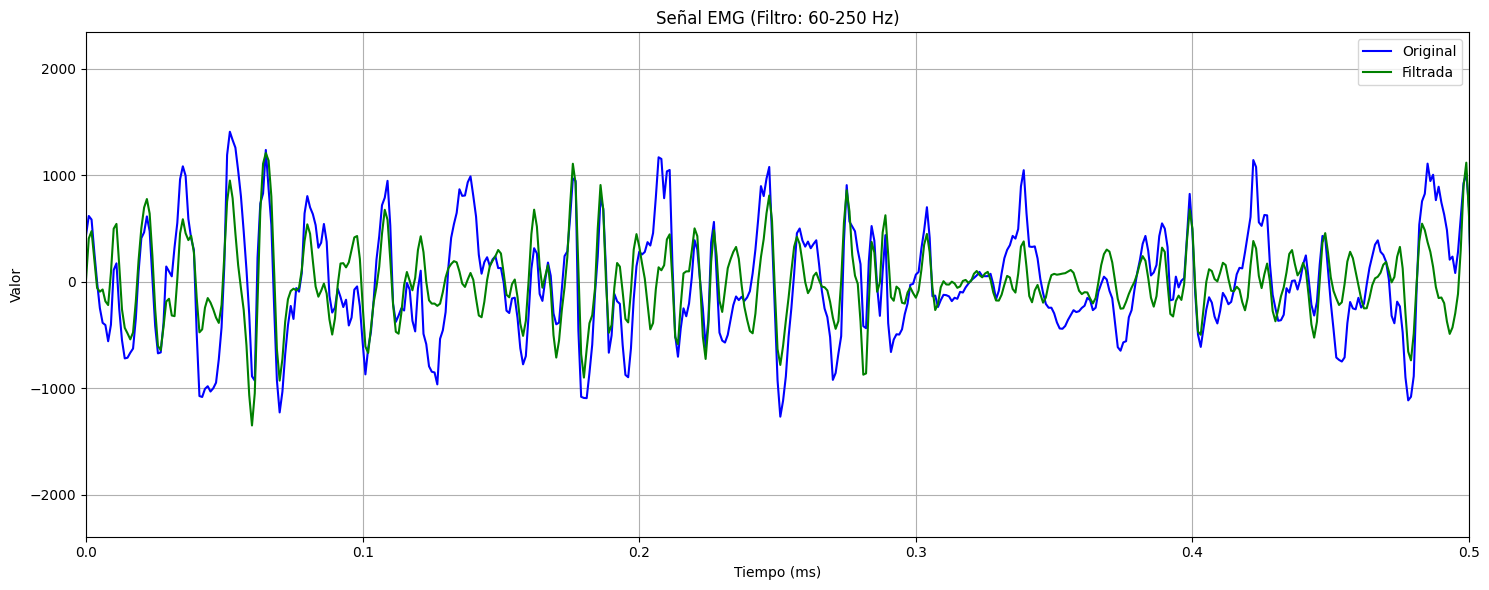

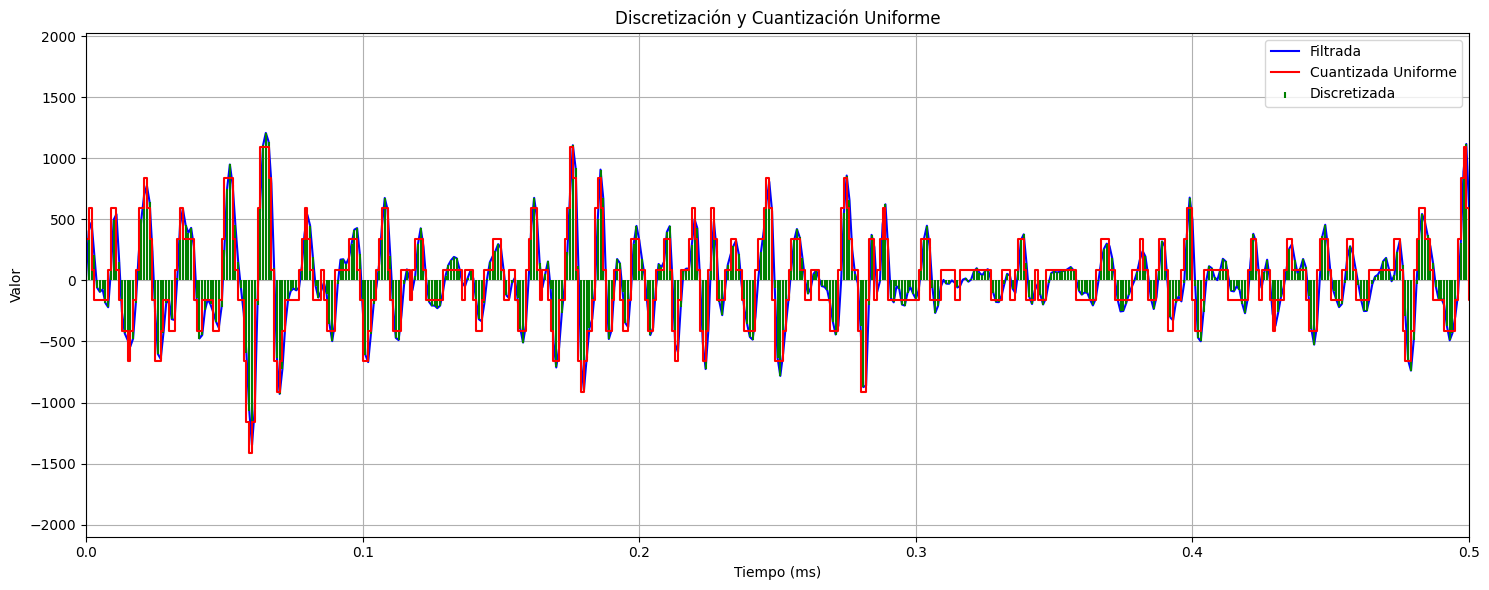

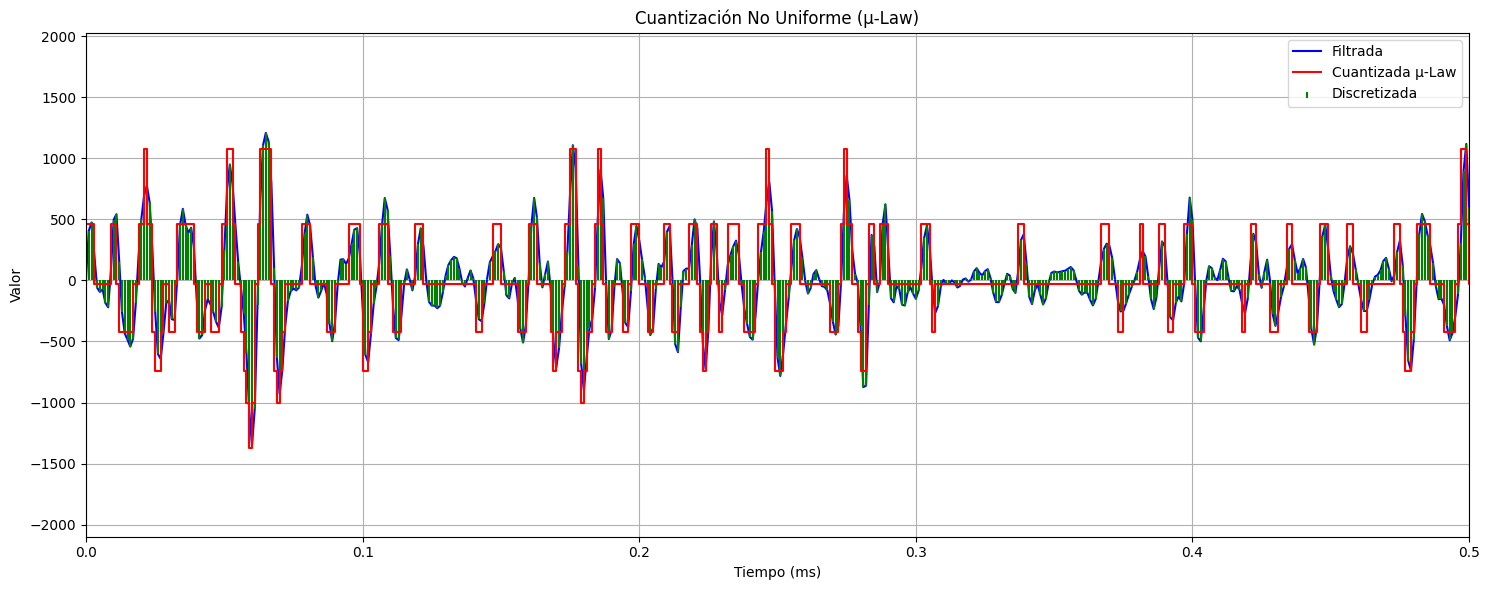

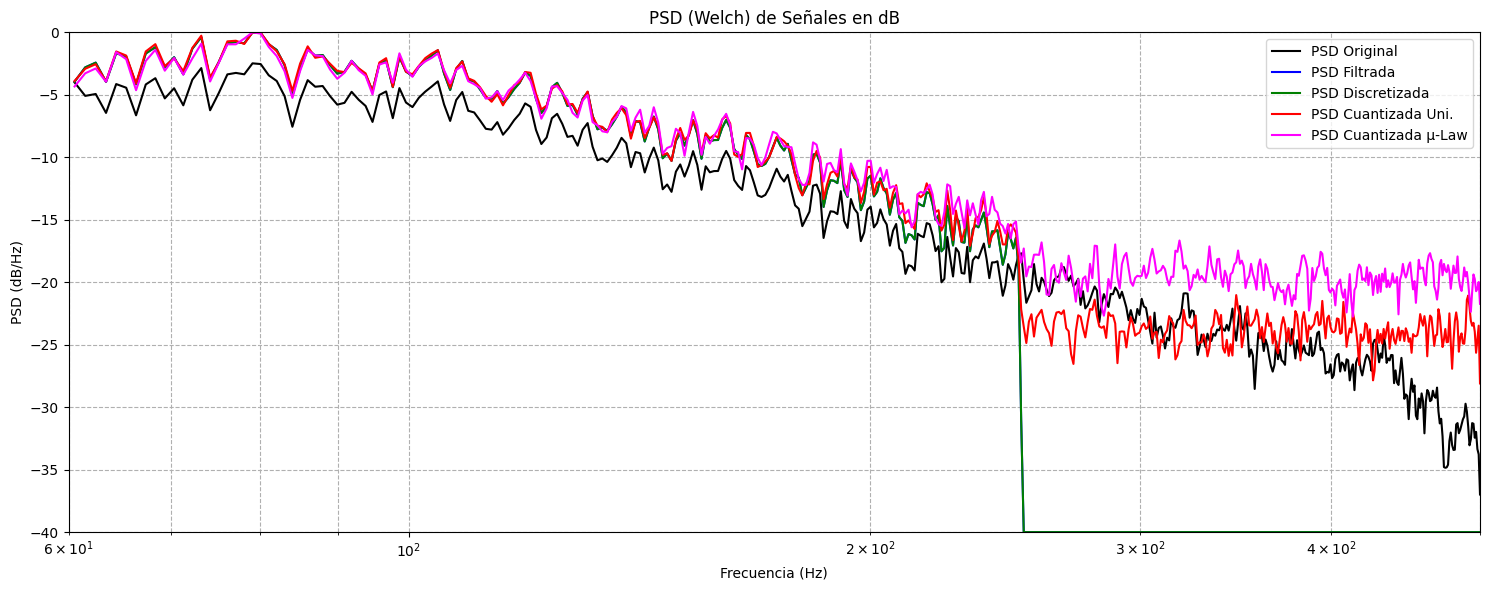

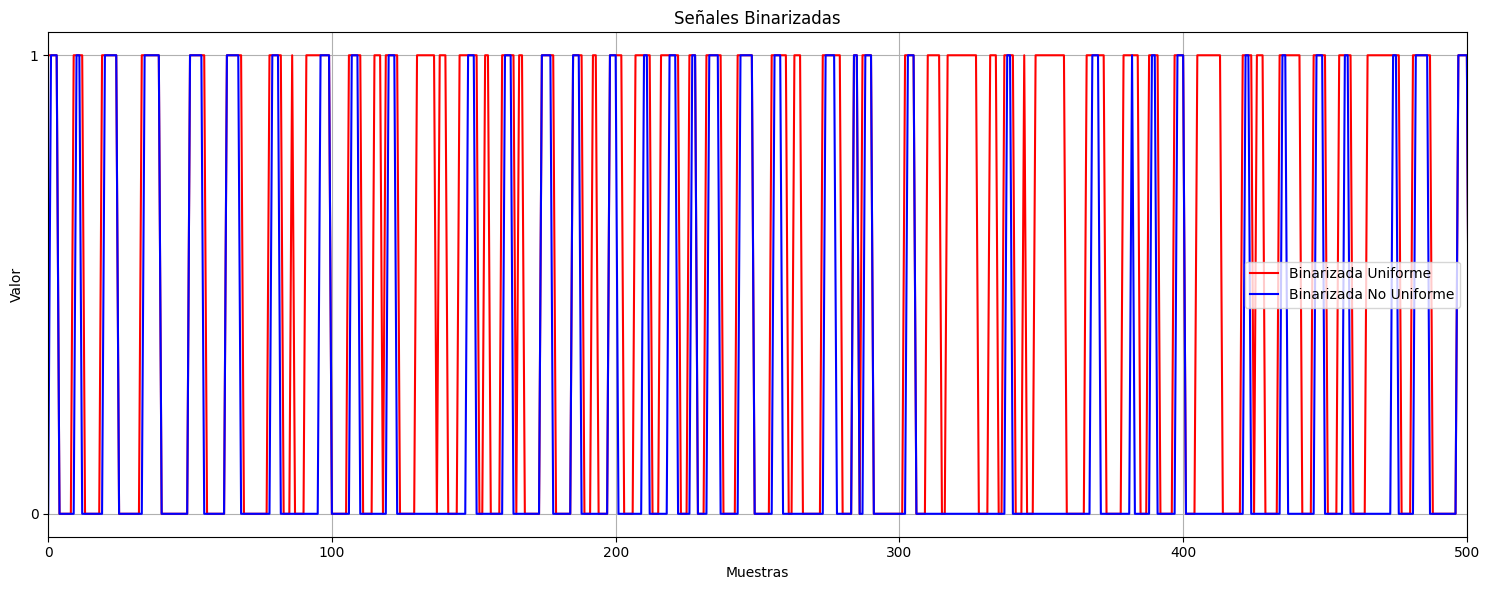

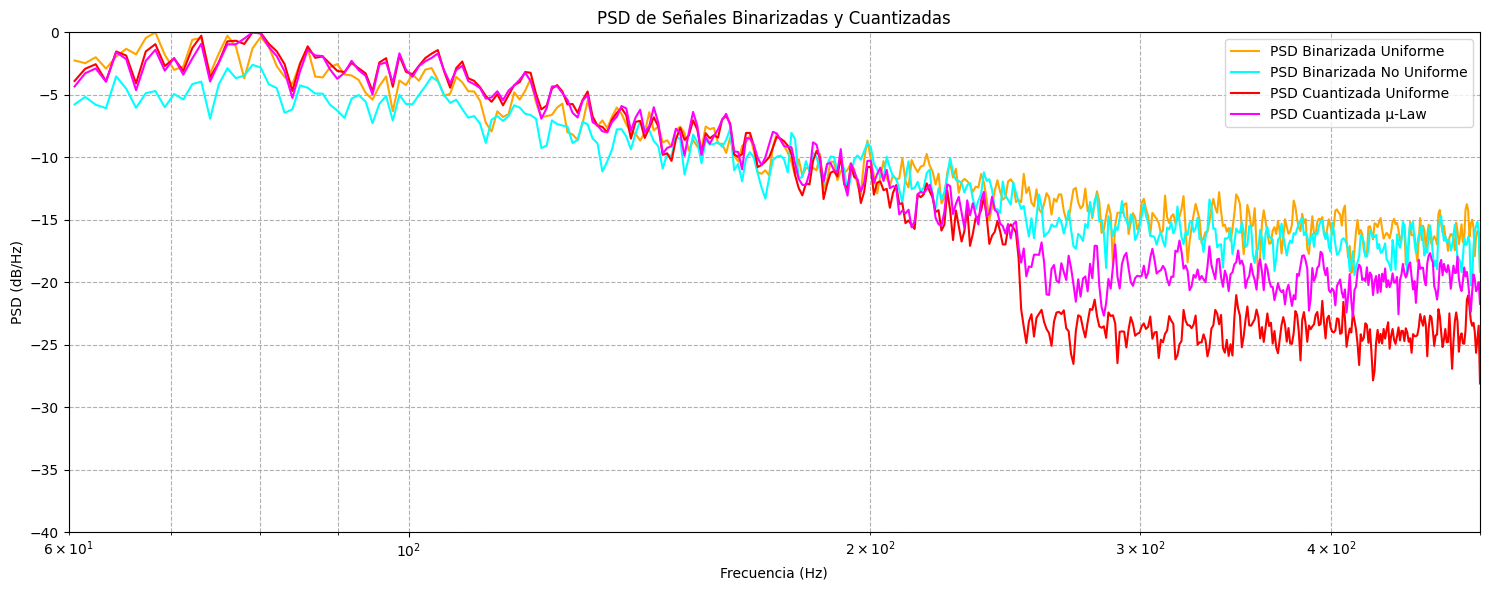

Cuantización Uniforme:
  Longitud original: 9500 bits
  Longitud comprimida: 7444 bits
  Tasa de compresión: 21.64%

Cuantización μ-law:
  Longitud original: 9500 bits
  Longitud comprimida: 5544 bits
  Tasa de compresión: 41.64%


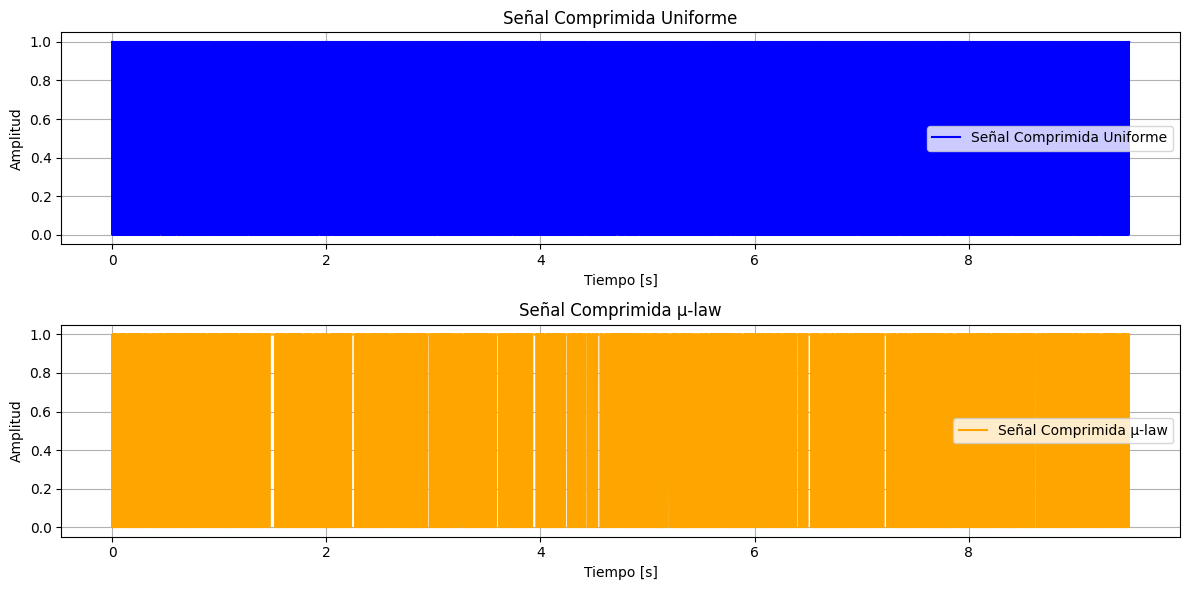

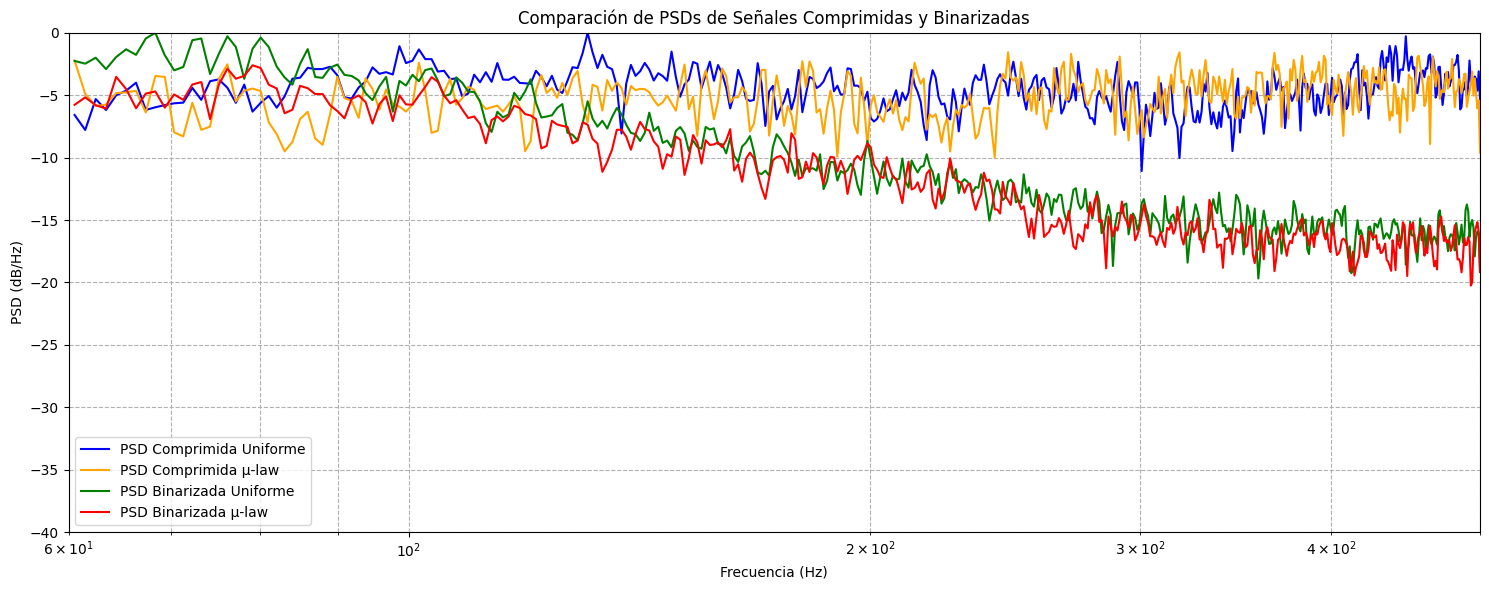

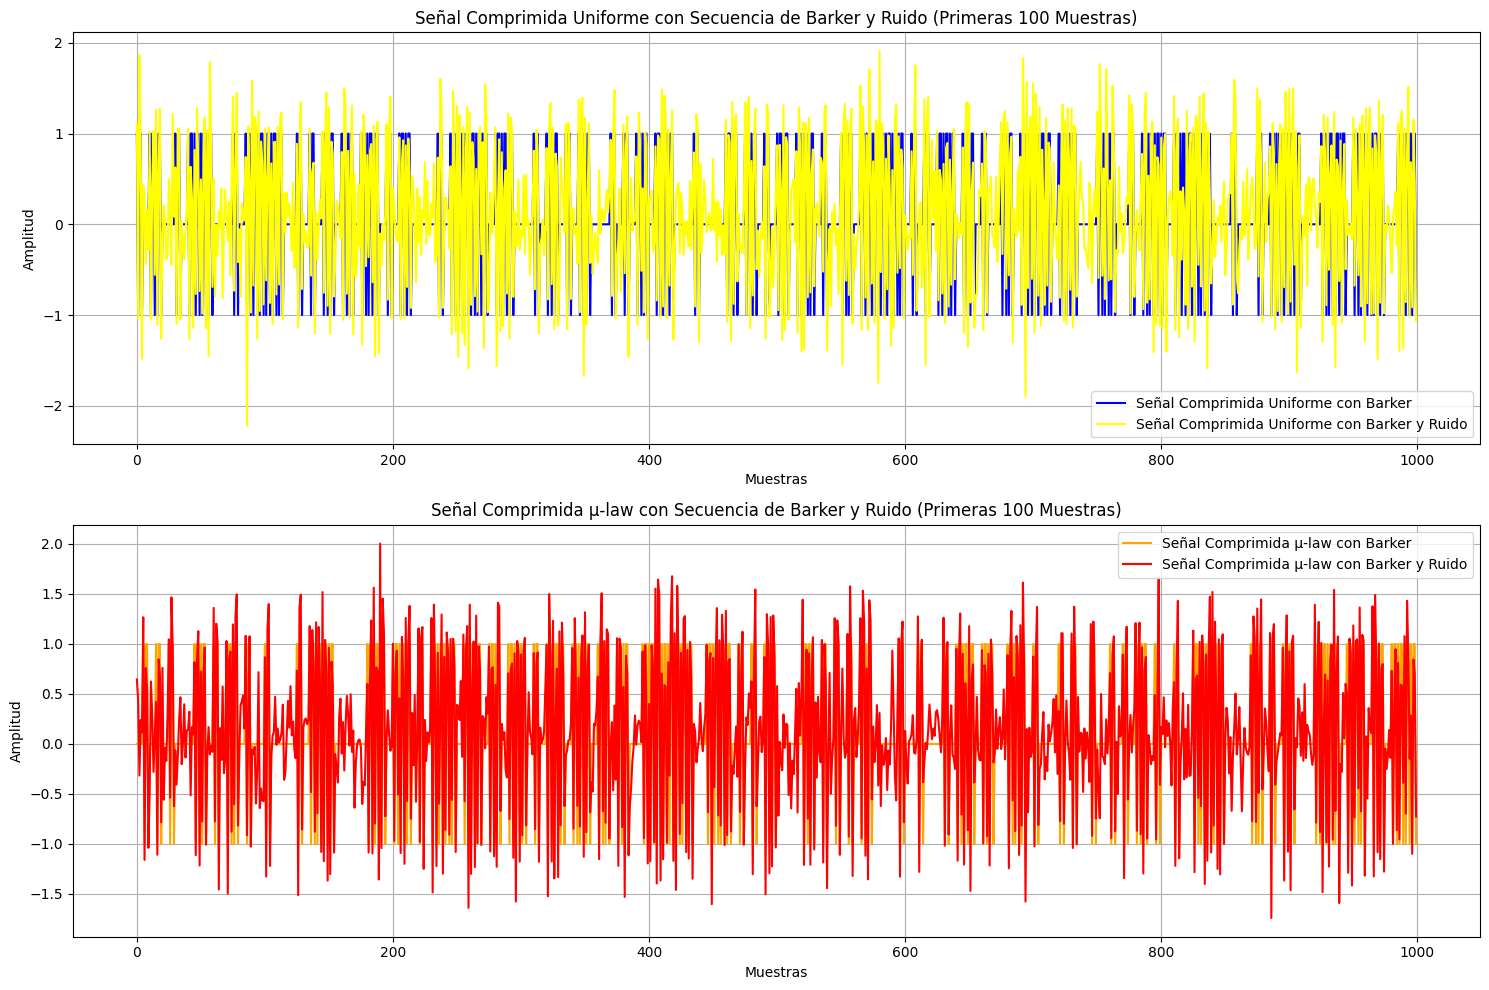

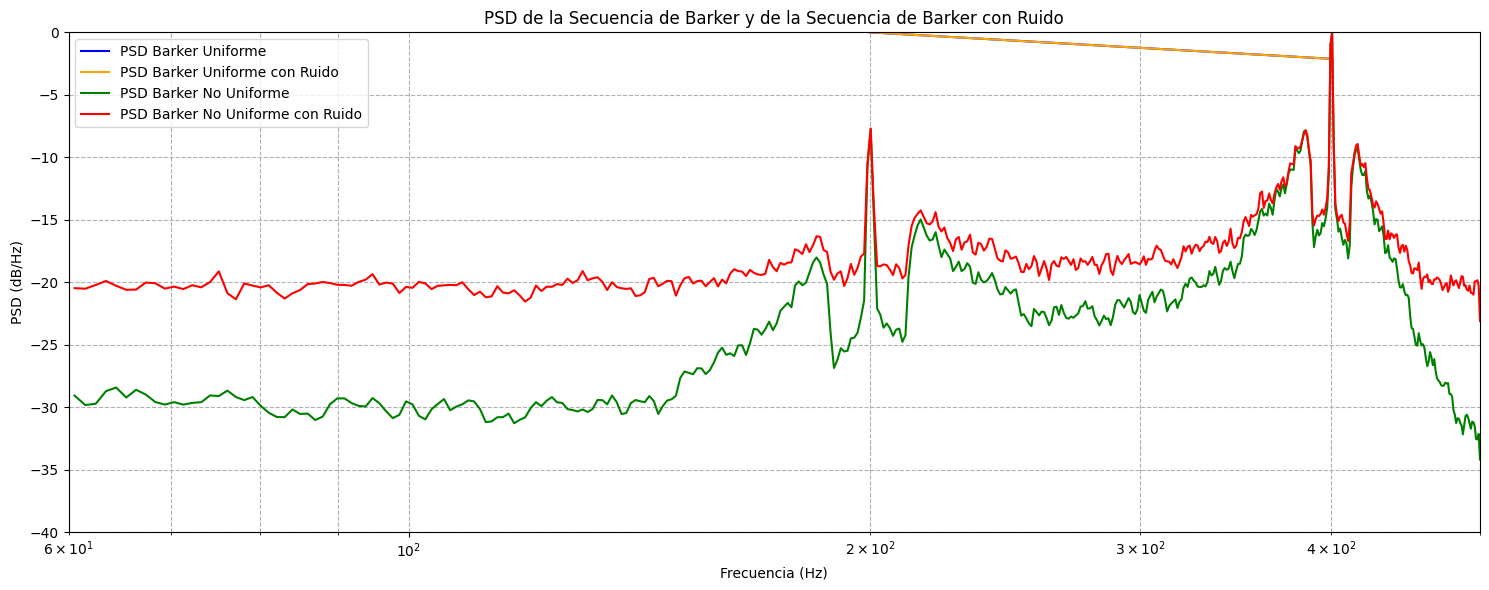

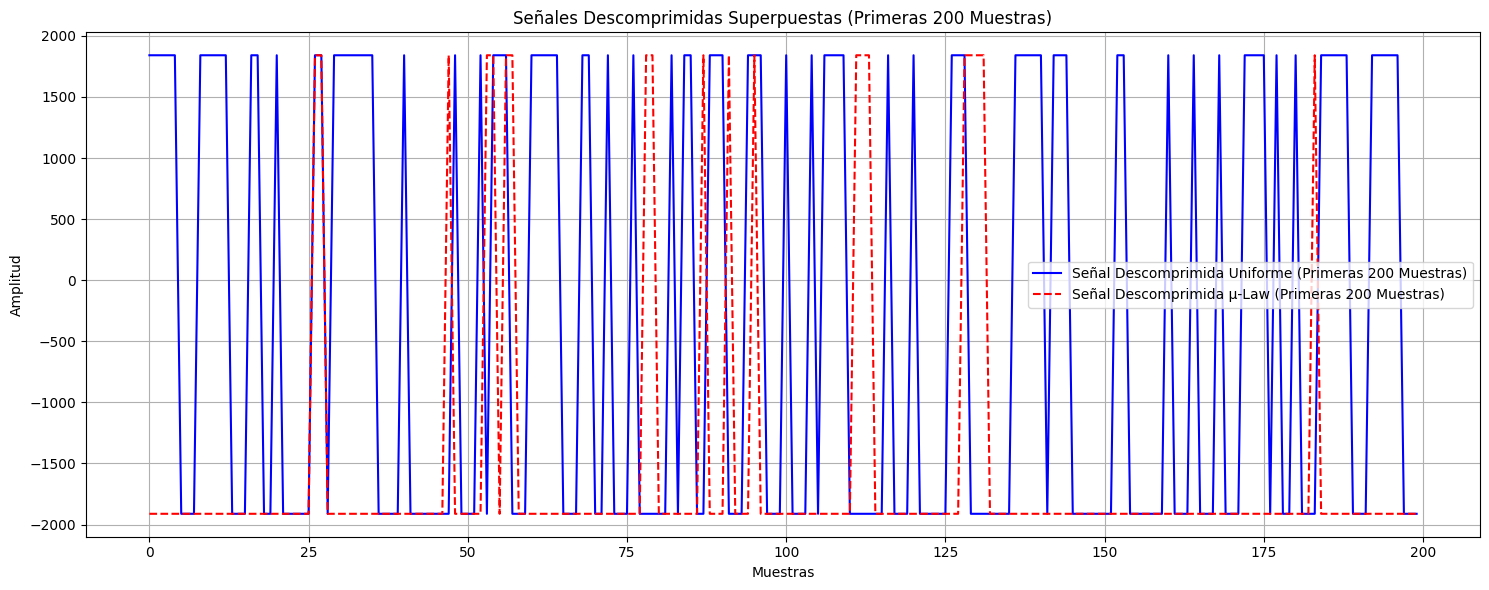

Probabilidad de error entre la señal comprimida uniforme y la señal descomprimida: 1.0000
Probabilidad de error entre la señal comprimida μ-Law y la señal descomprimida: 1.0000
Probabilidad de error entre la señal de Barker y la señal de Barker con ruido: 1.0000


In [43]:
def main():
    # Ruta del archivo CSV
    csv_path = "/content/drive/MyDrive/Signal Theory/Running_Columna_2_Tiempo.csv"

    # Procesamiento de la señal
    tdp = TimeDomainProcessor(csv_path, tiempo_a_graficar=9.5); tdp.mount_drive(); tdp.load_and_filter(); tdp.compute_fft(); tdp.apply_bandpass_filter(60, 250); tdp.plot_time_domain()

    # Cuantización y discretización
    dq = DiscreteQuantProcessor(tdp.tiempo_filtrado, tdp.señal_filtrada_freq); t_discreto, señal_discreta = dq.discretize_signal(sampling_rate=1000); señal_qunif = dq.quantize_uniform(señal_discreta, señal_discreta.min(), señal_discreta.max(), 2**4); señal_qmu = dq.quantize_mu_law(señal_discreta, L=16, mu=25); dq.plot_discretized_quantized(t_discreto, señal_discreta, señal_qunif); dq.plot_quantized_mu(t_discreto, señal_qmu)

    # PSD
    psd_processor = PSDProcessor(tdp.fs, 60); psd_processor.plot_psd(tdp.señal_filtrada, tdp.señal_filtrada_freq, señal_discreta, señal_qunif, señal_qmu)

    # Binarización
    binarization = Binarization(señal_qunif, señal_qmu); binarization.binarize(threshold=0); binarization.plot_binarized_signals(); psd_processor.plot_binarized_psd(binarization.señal_binarizada_uni, binarization.señal_binarizada_no_uni, señal_qunif, señal_qmu)

    # Huffman
    huffman_analyzer = HuffmanSignalAnalyzer(binarization.señal_binarizada_uni, binarization.señal_binarizada_no_uni, fs_binary=tdp.fs, block_size=4); huffman_analyzer.print_compression_rate(); huffman_analyzer.plot_compressed_signals(); psd_processor.plot_combined_psd(huffman_analyzer.compressed_uniform, huffman_analyzer.compressed_mu, binarization.señal_binarizada_uni, binarization.señal_binarizada_no_uni)

    # Secuencia de Barker
    barker_processor = Barker([1, -1, 1, 1, -1], huffman_analyzer.compressed_uniform, huffman_analyzer.compressed_mu, huffman_analyzer); barker_processor.plot_signals()

    # Señales de Barker
    barker_signal_no_uniform = barker_processor.apply_barker(binarization.señal_binarizada_no_uni); barker_signal_no_uniform_noisy = barker_processor.add_gaussian_noise(barker_signal_no_uniform, power=0.1); psd_processor.plot_psd_barker(barker_processor.barker_sequence, barker_processor.barker_sequence + 0.1, barker_signal_no_uniform, barker_signal_no_uniform_noisy)

    # Procesar señales
    barker_uniform_noisy = barker_processor.add_gaussian_noise(barker_processor.apply_barker(huffman_analyzer.compressed_uniform), power=0.1); decompressed_uniform = barker_processor.dismantle_and_decompress(barker_uniform_noisy, is_uniform=True)
    barker_mu_noisy = barker_processor.add_gaussian_noise(barker_processor.apply_barker(huffman_analyzer.compressed_mu), power=0.1); decompressed_mu = barker_processor.dismantle_and_decompress(barker_mu_noisy, is_uniform=False)

    # Decodificación
    decoded_uniform = huffman_analyzer.decode_to_original_scale(decompressed_uniform, señal_discreta.min(), señal_discreta.max())
    decoded_mu = huffman_analyzer.decode_to_original_scale(decompressed_mu, señal_qmu.min(), señal_qmu.max())

    # Graficar señales descomprimidas
    plt.figure(figsize=(15, 6)); plt.plot(decoded_uniform[:200], 'b-', label='Señal Descomprimida Uniforme (Primeras 200 Muestras)'); plt.plot(decoded_mu[:200], 'r--', label='Señal Descomprimida μ-Law (Primeras 200 Muestras)'); plt.title('Señales Descomprimidas Superpuestas (Primeras 200 Muestras)'); plt.xlabel('Muestras'); plt.ylabel('Amplitud'); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


    # Calcular y mostrar probabilidades de error
    ProError(huffman_analyzer.compressed_uniform, decoded_uniform).print_error_probability("la señal comprimida uniforme y la señal descomprimida")
    ProError(huffman_analyzer.compressed_mu, decoded_mu).print_error_probability("la señal comprimida μ-Law y la señal descomprimida")
    ProError(barker_signal_no_uniform, barker_signal_no_uniform_noisy).print_error_probability("la señal de Barker y la señal de Barker con ruido")

# Llamar a la función principal
if __name__ == "__main__":
    main()